# 0. Import Dependencies

In [47]:
import warnings
warnings.filterwarnings("ignore")

import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from torchsummary import summary
from itertools import product
from torch.utils.tensorboard import  SummaryWriter

from torchvision import models

from torch.optim.lr_scheduler import StepLR

# 1. Data Preparation

## 1.1 Data Load

In [134]:
class DataSet(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label

In [135]:
dataset = DataSet(csv_file="./data/f1_classification/f111.csv",
                  root_dir="./data",
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize((28,28)),
                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                  ]))

## 1.2 Data Preproccesing

In [136]:
data_lengths = (int(len(dataset)*.75), len(dataset) - int(len(dataset)*.75))

In [137]:
train_data, test_data = torch.utils.data.random_split(dataset, data_lengths)

In [138]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True, drop_last=True)

## 1.3 Data Visualization

In [7]:
classes = ['Ferrari', 'Mclaren', 'Mercedes', 'Redbull']

def show_image(img):
    img = img / 2 + 0.5
    np_img = np.array(img)
    plt.imshow(np.transpose(np_img, (1,2,0)))
    plt.show()

In [8]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([8, 3, 28, 28])


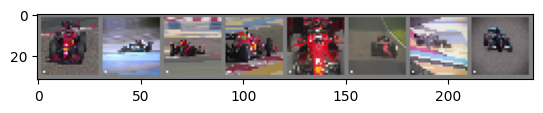

Ferrari, Mercedes, Redbull, Ferrari, Ferrari, Ferrari, Mercedes, Mercedes
torch.Size([8, 3, 28, 28])


In [9]:
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))
print(', '.join('%5s' % classes[labels[j]] for j in range(8)))
print(images.size())

# 2. Model

## 2.1 Model Building

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, (3,3))
        self.conv2 = nn.Conv2d(16, 32, (3,3))
        self.conv3 = nn.Conv2d(32, 64, (3,3))
        self.maxpool = nn.MaxPool2d((2,2))
        self.dense1 = nn.Linear(64, 256)
        self.dense2 = nn.Linear(256, 512)
        self.dense3 = nn.Linear(512, 4)
        self.flatten = nn.Flatten()

        self.elu = nn.ELU()
        self.softmax = nn.Softmax()

    def forward(self, input):
        x = self.conv1(input)
        x = self.elu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.elu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.elu(x)
        x = self.maxpool(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.elu(x)

        x = self.dense2(x)
        x = self.elu(x)

        x = self.dense3(x)
        x = self.elu(x)

        output = self.softmax(x)

        return output

## 2.2 First Model Training

In [11]:
model = Model()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20

In [12]:
def train(model, train_loader, epochs, optimizer, criterion):
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            preds = model(images)

            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

        print(f"epoch:{epoch}, loss:{loss}")

In [13]:
train(model, train_loader, epochs, optimizer, criterion)

epoch:0, loss:1.2874866724014282
epoch:1, loss:0.9105756282806396
epoch:2, loss:1.231785774230957
epoch:3, loss:1.1642651557922363
epoch:4, loss:0.9650707244873047
epoch:5, loss:0.7661697268486023
epoch:6, loss:1.6375409364700317
epoch:7, loss:1.0125516653060913
epoch:8, loss:1.105716347694397
epoch:9, loss:0.7686039805412292
epoch:10, loss:0.8405172824859619
epoch:11, loss:1.6604504585266113
epoch:12, loss:0.8035686612129211
epoch:13, loss:0.7793405652046204
epoch:14, loss:1.086300015449524
epoch:15, loss:0.7457816004753113
epoch:16, loss:0.8674195408821106
epoch:17, loss:0.7793479561805725
epoch:18, loss:0.7524368762969971
epoch:19, loss:0.7437045574188232


In [14]:
def evaluate(test_loader, model):
    num_correct = 0
    num_sample = 0
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images)
            _, pred = preds.max(axis = 1)
            num_correct += (pred==labels).sum()
            num_sample += pred.size(0)
        print(f"acc: {float(num_correct)/float(num_sample)*100}")
        model.train()

In [15]:
print("Train")
evaluate(train_loader, model)
print("Test")
evaluate(test_loader, model)

Train
acc: 91.86602870813397
Test
acc: 74.28571428571429


## 2.3 Second Model Training

In [16]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20

In [17]:
def train(model, train_loader, test_loader, epochs, optimizer, criterion):
    losses = []
    iteration = []
    acc = []
    count = 0
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            preds = model(images)

            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            count += 1

            if count % 50 == 0:
                num_sample = 0
                num_correct = 0
                num_error = 0

                for images, labels in test_loader:
                    preds = model(images)
                    pred = torch.max(preds.data, 1)[1]
                    num_correct += (pred==labels).sum()
                    num_error += (pred!=labels).sum()
                    num_sample += pred.size(0)

                accuracy = 100*num_correct/float(num_sample)

                losses.append(loss.data)
                iteration.append(count)
                acc.append(accuracy)

                print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")
    return losses, iteration, acc

In [18]:
losses, iteration, acc= train(model, train_loader, test_loader, epochs, optimizer, criterion)

Iteration : 50, Loss : 1.0561537742614746, Accuracy : 61.42856979370117
Iteration : 100, Loss : 0.9918251633644104, Accuracy : 78.57142639160156
Iteration : 150, Loss : 1.0257880687713623, Accuracy : 77.14286041259766
Iteration : 200, Loss : 0.9577130079269409, Accuracy : 81.42857360839844
Iteration : 250, Loss : 0.7457163333892822, Accuracy : 82.85713958740234
Iteration : 300, Loss : 0.860470712184906, Accuracy : 82.85713958740234
Iteration : 350, Loss : 0.8597078323364258, Accuracy : 85.71428680419922
Iteration : 400, Loss : 0.8650158643722534, Accuracy : 81.42857360839844
Iteration : 450, Loss : 0.7451851963996887, Accuracy : 85.71428680419922
Iteration : 500, Loss : 0.7439547181129456, Accuracy : 82.85713958740234


# 3. Model Save and Load

In [19]:
#model save
torch.save(model, './models/model.pt')

In [20]:
#model load
model = torch.load('./models/model.pt')

# 4. Metric Visualization

In [21]:
summary(model, input_data=(3,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 26, 26]          448
├─ELU: 1-2                               [-1, 16, 26, 26]          --
├─MaxPool2d: 1-3                         [-1, 16, 13, 13]          --
├─Conv2d: 1-4                            [-1, 32, 11, 11]          4,640
├─ELU: 1-5                               [-1, 32, 11, 11]          --
├─MaxPool2d: 1-6                         [-1, 32, 5, 5]            --
├─Conv2d: 1-7                            [-1, 64, 3, 3]            18,496
├─ELU: 1-8                               [-1, 64, 3, 3]            --
├─MaxPool2d: 1-9                         [-1, 64, 1, 1]            --
├─Flatten: 1-10                          [-1, 64]                  --
├─Linear: 1-11                           [-1, 256]                 16,640
├─ELU: 1-12                              [-1, 256]                 --
├─Linear: 1-13                           [-1, 512]                 131,58

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 26, 26]          448
├─ELU: 1-2                               [-1, 16, 26, 26]          --
├─MaxPool2d: 1-3                         [-1, 16, 13, 13]          --
├─Conv2d: 1-4                            [-1, 32, 11, 11]          4,640
├─ELU: 1-5                               [-1, 32, 11, 11]          --
├─MaxPool2d: 1-6                         [-1, 32, 5, 5]            --
├─Conv2d: 1-7                            [-1, 64, 3, 3]            18,496
├─ELU: 1-8                               [-1, 64, 3, 3]            --
├─MaxPool2d: 1-9                         [-1, 64, 1, 1]            --
├─Flatten: 1-10                          [-1, 64]                  --
├─Linear: 1-11                           [-1, 256]                 16,640
├─ELU: 1-12                              [-1, 256]                 --
├─Linear: 1-13                           [-1, 512]                 131,58

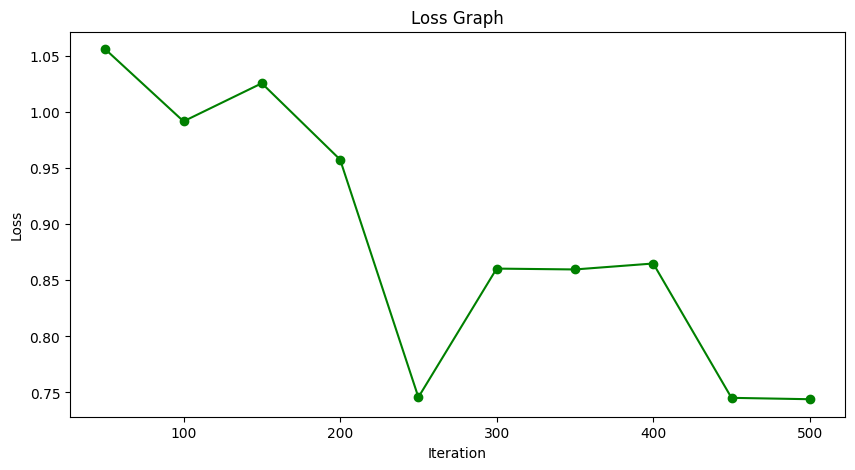

In [22]:
plt.figure(figsize=(10,5))
plt.title('Loss Graph')
plt.plot(iteration, losses, '-o', color = 'g')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

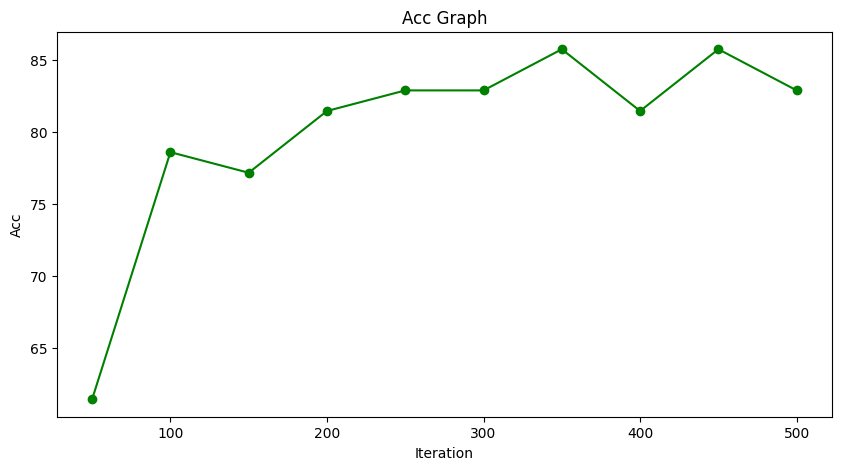

In [23]:
plt.figure(figsize=(10,5))
plt.title('Acc Graph')
plt.plot(iteration, acc, '-o', color = 'g')
plt.xlabel('Iteration')
plt.ylabel('Acc')
plt.show()

In [24]:
class_name = ['Ferrari', 'McLaren', 'Mercedes', 'Redbull']

In [25]:
def vis(model, number_of_image = 6):
    was_training = model.training
    image_count = 0
    model.eval()
    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            outputs = model(images.to('cuda'))

            _, outputs = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                plt.figure(figsize = (40,30))
                image_count += 1
                ax = plt.subplot(number_of_image//2, 2, image_count)
                ax.set_title(f"Predict: {class_name[outputs[j]]}")
                plt.imshow(images.cpu().data[j].reshape(28,28,3))
                if number_of_image == image_count:
                    model.train(mode = was_training)
                    return

# 5. Sequential Model

In [26]:
model = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = (5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = (3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (2,2)),
    nn.ReLU(),
    nn.Flatten(),

    nn.Linear(in_features=32, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=4)
)

In [27]:
model

Sequential(
  (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (10): ReLU()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=32, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=64, bias=True)
  (15): ReLU()
  (16): Linear(in_features=64, out_features=128, bias=True)
  (17): ReLU()
  (18): Linear(in_features=128, out_features=4, bias=True)
)

In [28]:
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20

In [29]:
def train(model, train_loader, test_loader, epochs, optimizer, criterion):
    losses = []
    iteration = []
    acc = []
    count = 0
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            preds = model(images)

            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            count += 1

            if count % 50 == 0:
                num_sample = 0
                num_correct = 0
                num_error = 0

                for images, labels in test_loader:
                    preds = model(images)
                    pred = torch.max(preds.data, 1)[1]
                    num_correct += (pred==labels).sum()
                    num_error += (pred!=labels).sum()
                    num_sample += pred.size(0)

                accuracy = 100*num_correct/float(num_sample)

                losses.append(loss.data)
                iteration.append(count)
                acc.append(accuracy)

                print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")
    return losses, iteration, acc

In [30]:
losses, iteration, acc = train(model, train_loader, test_loader, epochs, optimizer, criterion)

Iteration : 50, Loss : 1.354993224143982, Accuracy : 21.428571701049805
Iteration : 100, Loss : 1.3761097192764282, Accuracy : 22.85714340209961
Iteration : 150, Loss : 1.3836777210235596, Accuracy : 25.714284896850586
Iteration : 200, Loss : 1.4320998191833496, Accuracy : 28.571428298950195
Iteration : 250, Loss : 1.3871417045593262, Accuracy : 42.85714340209961
Iteration : 300, Loss : 1.115393877029419, Accuracy : 45.71428680419922
Iteration : 350, Loss : 1.0350602865219116, Accuracy : 61.42856979370117
Iteration : 400, Loss : 1.0080132484436035, Accuracy : 70.0
Iteration : 450, Loss : 0.7192388772964478, Accuracy : 67.14286041259766
Iteration : 500, Loss : 0.7374241352081299, Accuracy : 61.42856979370117


In [31]:
def evaluate(test_loader, model):
    num_correct = 0
    num_sample = 0
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images)
            _, pred = preds.max(axis = 1)
            num_correct += (pred==labels).sum()
            num_sample += pred.size(0)
        print(f"acc: {float(num_correct)/float(num_sample)*100}")
        model.train()

In [32]:
print("Train")
evaluate(train_loader, model)
print("Test")
evaluate(test_loader, model)

Train
acc: 55.50239234449761
Test
acc: 74.28571428571429


# 6. Data Augmentation

In [33]:
data_augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((500,500)),
    # transforms.CenterCrop(),
    # transforms.RandomCrop(),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    transforms.GaussianBlur(kernel_size=1),
    transforms.RandomPerspective()
])

In [34]:
class DataSet(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label

dataset = DataSet(csv_file="./data/f1_classification/f111.csv",
                    root_dir="./data",
                    transform=data_augmentation)
len(dataset)

279

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


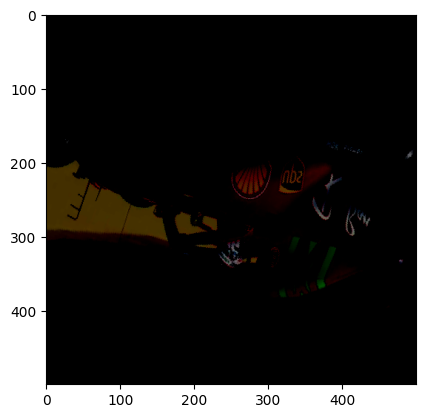

In [35]:

for img, label in dataset:
    plt.imshow(img.permute(1, 2, 0))
    break

# 7. Model Train with GPU

In [36]:
model = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = (5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = (3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (2,2)),
    nn.ReLU(),
    nn.Flatten(),

    nn.Linear(in_features=32, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=4)
)

In [37]:
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda")
epochs = 20

model.to(device)

Sequential(
  (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (10): ReLU()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=32, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=64, bias=True)
  (15): ReLU()
  (16): Linear(in_features=64, out_features=128, bias=True)
  (17): ReLU()
  (18): Linear(in_features=128, out_features=4, bias=True)
)

In [38]:
def train(model, train_loader, test_loader, epochs, optimizer, criterion):
    losses = []
    iteration = []
    acc = []
    count = 0
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            preds = model(images)

            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            count += 1

            if count % 50 == 0:
                num_sample = 0
                num_correct = 0
                num_error = 0

                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    preds = model(images)
                    pred = torch.max(preds.data, 1)[1]
                    num_correct += (pred==labels).sum()
                    num_error += (pred!=labels).sum()
                    num_sample += pred.size(0)

                accuracy = 100*num_correct/float(num_sample)

                losses.append(loss.data)
                iteration.append(count)
                acc.append(accuracy)

                print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")
    return losses, iteration, acc

In [39]:
losses, iteration, acc = train(model, train_loader, test_loader, epochs, optimizer, criterion)

Iteration : 50, Loss : 1.3824129104614258, Accuracy : 28.571428298950195
Iteration : 100, Loss : 1.3731768131256104, Accuracy : 28.571428298950195
Iteration : 150, Loss : 1.3543472290039062, Accuracy : 31.428571701049805
Iteration : 200, Loss : 1.1842613220214844, Accuracy : 37.14285659790039
Iteration : 250, Loss : 0.8778297305107117, Accuracy : 57.14285659790039
Iteration : 300, Loss : 0.9149536490440369, Accuracy : 58.57143020629883
Iteration : 350, Loss : 0.9215555787086487, Accuracy : 60.0
Iteration : 400, Loss : 1.0970197916030884, Accuracy : 60.0
Iteration : 450, Loss : 0.6861847043037415, Accuracy : 64.28571319580078
Iteration : 500, Loss : 0.8122935891151428, Accuracy : 65.71428680419922


# 8. Learning Rate Scheduler

In [40]:
model = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = (5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = (3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (2,2)),
    nn.ReLU(),
    nn.Flatten(),

    nn.Linear(in_features=32, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=4)
)

In [41]:
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda")

lrs = StepLR(optimizer, step_size = 5, gamma = 0.90)

epochs = 20

model.to(device)

Sequential(
  (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (10): ReLU()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=32, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=64, bias=True)
  (15): ReLU()
  (16): Linear(in_features=64, out_features=128, bias=True)
  (17): ReLU()
  (18): Linear(in_features=128, out_features=4, bias=True)
)

In [42]:
def train(model, train_loader, test_loader, epochs, optimizer, criterion):
    losses = []
    iteration = []
    acc = []
    count = 0
    for epoch in range(epochs):
        lrs.step()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            preds = model(images)

            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            count += 1

            if count % 50 == 0:
                num_sample = 0
                num_correct = 0
                num_error = 0

                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    preds = model(images)
                    pred = torch.max(preds.data, 1)[1]
                    num_correct += (pred==labels).sum()
                    num_error += (pred!=labels).sum()
                    num_sample += pred.size(0)

                accuracy = 100*num_correct/float(num_sample)

                losses.append(loss.data)
                iteration.append(count)
                acc.append(accuracy)

                print(f"Iteration : {count},  LRS : {lrs.get_lr()}, Loss : {loss.data}, Accuracy : {accuracy}")
    return losses, iteration, acc

In [43]:
losses, iteration, acc = train(model, train_loader, test_loader, epochs, optimizer, criterion)

Iteration : 50,  LRS : [0.001], Loss : 1.383115291595459, Accuracy : 20.0
Iteration : 100,  LRS : [0.001], Loss : 1.4109748601913452, Accuracy : 20.0
Iteration : 150,  LRS : [0.0009000000000000001], Loss : 1.3746888637542725, Accuracy : 31.428571701049805
Iteration : 200,  LRS : [0.0009000000000000001], Loss : 1.350890874862671, Accuracy : 40.0
Iteration : 250,  LRS : [0.000729], Loss : 1.2863552570343018, Accuracy : 44.28571319580078
Iteration : 300,  LRS : [0.0008100000000000001], Loss : 1.2249631881713867, Accuracy : 57.14285659790039
Iteration : 350,  LRS : [0.0008100000000000001], Loss : 0.8505961894989014, Accuracy : 60.0
Iteration : 400,  LRS : [0.0006561000000000001], Loss : 0.9098547697067261, Accuracy : 55.71428680419922
Iteration : 450,  LRS : [0.000729], Loss : 0.8196295499801636, Accuracy : 61.42857360839844
Iteration : 500,  LRS : [0.000729], Loss : 0.7760692834854126, Accuracy : 58.57143020629883


# 9. Tensorboard

In [44]:
start = time.time()
parameter = {"lr":[0.1, 0.01, 0.001], "batch_size":[1, 2]}
parameter_values = [v for v in parameter.values()]

for lr, batch_size in product(*parameter_values):
    model = Model()
    optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)

    tensorboard = SummaryWriter(comment=f"batch_size={batch_size} lr={lr}")
    tensorboard.add_image('images', grid)
    tensorboard.add_graph(model, images)

    losses = []
    iteration = []
    acc = []
    count = 0
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            preds = model(images)

            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            count += 1

            if count % 50 == 0:
                num_sample = 0
                num_correct = 0
                num_error = 0

                for images, labels in test_loader:
                    preds = model(images)
                    pred = torch.max(preds.data, 1)[1]
                    num_correct += (pred==labels).sum()
                    num_error += (pred!=labels).sum()
                    num_sample += pred.size(0)

                accuracy = 100*num_correct/float(num_sample)

                losses.append(loss.data)
                iteration.append(count)
                acc.append(accuracy)

                tensorboard.add_scalar("Loss", loss.data, epoch)
                tensorboard.add_scalar("Accuracy", accuracy, epoch)
                tensorboard.add_hparams({"lr":lr, "batch_size":batch_size},{"acc":accuracy, "loss":loss.data})

                print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")
            tensorboard.close()

Iteration : 50, Loss : 1.2309300899505615, Accuracy : 48.57143020629883
Iteration : 100, Loss : 0.9244711399078369, Accuracy : 62.85714340209961
Iteration : 150, Loss : 0.7855045199394226, Accuracy : 60.0
Iteration : 200, Loss : 0.827353835105896, Accuracy : 64.28571319580078
Iteration : 250, Loss : 0.9060966372489929, Accuracy : 68.57142639160156
Iteration : 300, Loss : 1.0242488384246826, Accuracy : 68.57142639160156
Iteration : 350, Loss : 0.9089072942733765, Accuracy : 70.0
Iteration : 400, Loss : 0.801669716835022, Accuracy : 75.71428680419922
Iteration : 450, Loss : 0.8604637980461121, Accuracy : 77.14286041259766
Iteration : 500, Loss : 0.8811855316162109, Accuracy : 78.57142639160156
Iteration : 50, Loss : 1.2927544116973877, Accuracy : 37.14285659790039
Iteration : 100, Loss : 1.1262437105178833, Accuracy : 42.85714340209961
Iteration : 150, Loss : 1.0370659828186035, Accuracy : 67.14286041259766
Iteration : 200, Loss : 0.894528865814209, Accuracy : 68.57142639160156
Iteration

In [45]:
# !tensorboard --logdir=runs

# 10. Transfer Learning

In [157]:
model = models.resnet34(pretrained=True)

In [158]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [159]:
def train(model, train_loader, test_loader, epochs, optimizer, criterion):
    losses = []
    iteration = []
    acc = []
    count = 0
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            preds = model(images)

            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            count += 1

            if count % 50 == 0:
                num_sample = 0
                num_correct = 0
                num_error = 0

                for images, labels in test_loader:
                    preds = model(images)
                    pred = torch.max(preds.data, 1)[1]
                    num_correct += (pred==labels).sum()
                    num_error += (pred!=labels).sum()
                    num_sample += pred.size(0)

                accuracy = 100*num_correct/float(num_sample)

                losses.append(loss.data)
                iteration.append(count)
                acc.append(accuracy)

                print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")
    return losses, iteration, acc

In [160]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 4)
)

optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 25

In [161]:
train(model, train_loader, test_loader, epochs, optimizer, criterion)

Iteration : 50, Loss : 1.1991195678710938, Accuracy : 31.25
Iteration : 100, Loss : 1.5621216297149658, Accuracy : 48.4375
Iteration : 150, Loss : 0.979896068572998, Accuracy : 59.375
Iteration : 200, Loss : 0.6323803067207336, Accuracy : 57.8125
Iteration : 250, Loss : 1.0720751285552979, Accuracy : 48.4375
Iteration : 300, Loss : 0.7637492418289185, Accuracy : 59.375
Iteration : 350, Loss : 1.2657352685928345, Accuracy : 57.8125
Iteration : 400, Loss : 0.5402598977088928, Accuracy : 57.8125
Iteration : 450, Loss : 0.7261233925819397, Accuracy : 65.625
Iteration : 500, Loss : 0.79813551902771, Accuracy : 59.375
Iteration : 550, Loss : 0.9669194221496582, Accuracy : 42.1875
Iteration : 600, Loss : 0.28195279836654663, Accuracy : 64.0625
Iteration : 650, Loss : 1.3819056749343872, Accuracy : 53.125


([tensor(1.1991),
  tensor(1.5621),
  tensor(0.9799),
  tensor(0.6324),
  tensor(1.0721),
  tensor(0.7637),
  tensor(1.2657),
  tensor(0.5403),
  tensor(0.7261),
  tensor(0.7981),
  tensor(0.9669),
  tensor(0.2820),
  tensor(1.3819)],
 [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650],
 [tensor(31.2500),
  tensor(48.4375),
  tensor(59.3750),
  tensor(57.8125),
  tensor(48.4375),
  tensor(59.3750),
  tensor(57.8125),
  tensor(57.8125),
  tensor(65.6250),
  tensor(59.3750),
  tensor(42.1875),
  tensor(64.0625),
  tensor(53.1250)])

In [162]:
def evaluate(test_loader, model):
    num_correct = 0
    num_sample = 0
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images)
            _, pred = preds.max(axis = 1)
            num_correct += (pred==labels).sum()
            num_sample += pred.size(0)
        print(f"acc: {float(num_correct)/float(num_sample)*100}")
        model.train()

In [163]:
print("Train")
evaluate(train_loader, model)
print("Test")
evaluate(test_loader, model)

Train
acc: 78.36538461538461
Test
acc: 59.375


# 11. Pretrained Models

In [164]:
model = models.googlenet(pretrained = False)

In [165]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [166]:
model.fc = nn.Linear(1024, 4, bias=True)

In [167]:
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 25

In [168]:
def train(model, train_loader, test_loader, epochs, optimizer, criterion):
    losses = []
    iteration = []
    acc = []
    count = 0
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            preds = model(images)

            loss = criterion(preds[1], labels)
            loss.backward()

            optimizer.step()

            count += 1

            if count % 50 == 0:
                num_sample = 0
                num_correct = 0
                num_error = 0

                for images, labels in test_loader:
                    preds = model(images)
                    pred = torch.max(preds[1].data, 1)[1]
                    num_correct += (pred==labels).sum()
                    num_error += (pred!=labels).sum()
                    num_sample += pred.size(0)

                accuracy = 100*num_correct/float(num_sample)

                losses.append(loss.data)
                iteration.append(count)
                acc.append(accuracy)

                print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")
    return losses, iteration, acc

In [169]:
train(model, train_loader, test_loader, epochs, optimizer, criterion)

Iteration : 50, Loss : 1.3886473178863525, Accuracy : 53.125
Iteration : 100, Loss : 1.242200493812561, Accuracy : 65.625
Iteration : 150, Loss : 0.6234537959098816, Accuracy : 67.1875
Iteration : 200, Loss : 0.6327561140060425, Accuracy : 68.75
Iteration : 250, Loss : 0.11396359652280807, Accuracy : 71.875
Iteration : 300, Loss : 0.18096981942653656, Accuracy : 75.0
Iteration : 350, Loss : 0.1063479334115982, Accuracy : 79.6875
Iteration : 400, Loss : 0.6430811285972595, Accuracy : 81.25
Iteration : 450, Loss : 0.033196382224559784, Accuracy : 68.75
Iteration : 500, Loss : 0.05114205181598663, Accuracy : 68.75
Iteration : 550, Loss : 0.39824575185775757, Accuracy : 81.25
Iteration : 600, Loss : 0.054600272327661514, Accuracy : 71.875
Iteration : 650, Loss : 0.02334875799715519, Accuracy : 71.875


([tensor(1.3886),
  tensor(1.2422),
  tensor(0.6235),
  tensor(0.6328),
  tensor(0.1140),
  tensor(0.1810),
  tensor(0.1063),
  tensor(0.6431),
  tensor(0.0332),
  tensor(0.0511),
  tensor(0.3982),
  tensor(0.0546),
  tensor(0.0233)],
 [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650],
 [tensor(53.1250),
  tensor(65.6250),
  tensor(67.1875),
  tensor(68.7500),
  tensor(71.8750),
  tensor(75.),
  tensor(79.6875),
  tensor(81.2500),
  tensor(68.7500),
  tensor(68.7500),
  tensor(81.2500),
  tensor(71.8750),
  tensor(71.8750)])